1. Import and Install the required libraries


In [96]:
import sys
!{sys.executable} -m pip install --upgrade pip
!{sys.executable} -m pip uninstall protobuf -y
!{sys.executable} -m pip uninstall mediapipe -y
!{sys.executable} -m pip uninstall tensorflow -y
!{sys.executable} -m pip uninstall opencv-python -y
!{sys.executable} -m pip uninstall opencv-python-headless -y
!{sys.executable} -m pip install notebook jupyterlab jupyter_server nbclient nbconvert nbformat ipywidgets --user
!{sys.executable} -m pip install opencv-python --user
!{sys.executable} -m pip install matplotlib --user
!{sys.executable} -m pip install protobuf==4.25.3 --user
!{sys.executable} -m pip install mediapipe --user
!{sys.executable} -m pip install tensorflow --user
!{sys.executable} -m pip install opencv-python-headless --user
!{sys.executable} -m pip install opencv-contrib-python --user
!{sys.executable} -m pip install ipython --user
!{sys.executable} -m pip install subprocess32 --user  
!{sys.executable} -m pip install threading --user  
!{sys.executable} -m pip install signal --user
!{sys.executable} -m pip install numpy --user
!{sys.executable} -m pip install seaborn --user

Found existing installation: protobuf 4.25.3
Uninstalling protobuf-4.25.3:
  Successfully uninstalled protobuf-4.25.3


You can safely remove it manually.


Found existing installation: mediapipe 0.10.21
Uninstalling mediapipe-0.10.21:
  Successfully uninstalled mediapipe-0.10.21


You can safely remove it manually.


Found existing installation: tensorflow 2.19.0
Uninstalling tensorflow-2.19.0:
  Successfully uninstalled tensorflow-2.19.0


You can safely remove it manually.


Found existing installation: opencv-python 4.11.0.86
Uninstalling opencv-python-4.11.0.86:
  Successfully uninstalled opencv-python-4.11.0.86


You can safely remove it manually.


Found existing installation: opencv-python-headless 4.11.0.86
Uninstalling opencv-python-headless-4.11.0.86:
  Successfully uninstalled opencv-python-headless-4.11.0.86


  Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python-4.11.0.86-cp37-abi3-win_amd64.whl (39.5 MB)


  Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl.metadata (541 bytes)
Using cached protobuf-4.25.3-cp310-abi3-win_amd64.whl (413 kB)


  Using cached mediapipe-0.10.21-cp310-cp310-win_amd64.whl.metadata (10 kB)
Using cached mediapipe-0.10.21-cp310-cp310-win_amd64.whl (51.0 MB)


  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl (375.7 MB)


ERROR: Could not install packages due to an OSError: [Errno 28] No space left on device




  Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl.metadata (20 kB)
Using cached opencv_python_headless-4.11.0.86-cp37-abi3-win_amd64.whl (39.4 MB)


ERROR: Could not find a version that satisfies the requirement threading (from versions: none)
ERROR: No matching distribution found for threading
ERROR: Could not find a version that satisfies the requirement signal (from versions: none)
ERROR: No matching distribution found for signal


In [97]:
import cv2
import numpy as np
import os
import pandas as pd
from IPython.display import display, Image, clear_output
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import time
import mediapipe as mp
import subprocess
import threading
import signal
import io
import ipywidgets as widgets
from PIL import Image
import asyncio



In [3]:
mp_holistic = mp.solutions.holistic #Holistic Model
mp_drawing = mp.solutions.drawing_utils # Drawing utilities
mp_face_mesh = mp.solutions.face_mesh

In [4]:
DATA_PATH = os.path.join('MP_Data')
actions = np.array(['hello', 'thanks', 'iloveyou'])
no_sequences = 30
sequence_length = 30

In [5]:
# Create directories for dataset storage
for action in actions:
    for sequence in range(no_sequences):
        os.makedirs(os.path.join(DATA_PATH, action, str(sequence)), exist_ok=True)

In [6]:
def mediapipe_detection(image, model):
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB) # COLOR CONVERSION BGR 2 RGB
    image.flags.writeable = False                  # Image is no longer writeable
    results = model.process(image)                 # Make prediction
    image.flags.writeable = True                   # Image is now writeable 
    image = cv2.cvtColor(image, cv2.COLOR_RGB2BGR) # COLOR COVERSION RGB 2 BGR
    return image, results

In [7]:
def draw_landmarks(image, results):
    mp_drawing.draw_landmarks(image, results.face_landmarks, mp_holistic.FACEMESH_TESSELATION) # Draw face connections
    mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS) # Draw pose connections
    mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw left hand connections
    mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS) # Draw right hand connections
    return image

In [8]:
# Keypoint extraction
def extract_keypoints(results):
    pose = np.array([[res.x, res.y, res.z, res.visibility] for res in results.pose_landmarks.landmark]).flatten() if results.pose_landmarks else np.zeros(33*4)
    face = np.array([[res.x, res.y, res.z] for res in results.face_landmarks.landmark]).flatten() if results.face_landmarks else np.zeros(468*3)
    lh = np.array([[res.x, res.y, res.z] for res in results.left_hand_landmarks.landmark]).flatten() if results.left_hand_landmarks else np.zeros(21*3)
    rh = np.array([[res.x, res.y, res.z] for res in results.right_hand_landmarks.landmark]).flatten() if results.right_hand_landmarks else np.zeros(21*3)
    return np.concatenate([pose, face, lh, rh])

In [9]:
def draw_styled_landmarks(image, results):
#     # Draw face landmarks
    if results.face_landmarks:
        mp_drawing.draw_landmarks(image, results.face_landmarks, mp_face_mesh.FACEMESH_TESSELATION,
                                mp_drawing.DrawingSpec(color=(80, 110, 10), thickness=1, circle_radius=1),
                                mp_drawing.DrawingSpec(color=(80, 256, 121), thickness=1, circle_radius=1))

#     # Draw pose landmarks
    if results.pose_landmarks:
       mp_drawing.draw_landmarks(image, results.pose_landmarks, mp_holistic.POSE_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(80, 22, 10), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(80, 44, 121), thickness=2, circle_radius=2))

#     # Draw left hand landmarks
    if results.left_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.left_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=2))

#     # Draw right hand landmarks
    if results.right_hand_landmarks:
        mp_drawing.draw_landmarks(image, results.right_hand_landmarks, mp_holistic.HAND_CONNECTIONS,
                                mp_drawing.DrawingSpec(color=(121, 44, 250), thickness=2, circle_radius=4),
                                mp_drawing.DrawingSpec(color=(121, 22, 76), thickness=2, circle_radius=2))

In [10]:
# Image Widget for Display
image_widget = widgets.Image()
display(image_widget)

async def collect_data():
    cap = cv2.VideoCapture(0)
    cap.set(cv2.CAP_PROP_FRAME_WIDTH, 640)
    cap.set(cv2.CAP_PROP_FRAME_HEIGHT, 480)
    cap.set(cv2.CAP_PROP_FPS, 60)
    loop = asyncio.get_event_loop()
    
    with mp_holistic.Holistic(min_detection_confidence=0.5, min_tracking_confidence=0.5) as holistic:
        for action in actions:
            for sequence in range(no_sequences):
                for frame_num in range(sequence_length):
                    ret, frame = await loop.run_in_executor(None, cap.read)
                    if not ret:
                        break
                    
                    frame, results = mediapipe_detection(frame, holistic)
                    draw_styled_landmarks(frame, results)
                    
                    if frame_num == 0:
                        cv2.putText(frame, 'STARTING COLLECTION', (120,200), cv2.FONT_HERSHEY_SIMPLEX, 1, (0, 255, 0), 4, cv2.LINE_AA)
                        cv2.putText(frame, f'Collecting frames for {action} Video Number {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                        
                        # Update Display
                        _, buffer = cv2.imencode('.jpg', frame)
                        image_widget.value = buffer.tobytes()
                        await asyncio.sleep(2)  # Display 'STARTING COLLECTION' for 2 seconds
                    else:
                        cv2.putText(frame, f'Collecting frames for {action} Video Number {sequence}', (15,12), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 255), 1, cv2.LINE_AA)
                    
                    # Update Display
                    _, buffer = cv2.imencode('.jpg', frame)
                    image_widget.value = buffer.tobytes()
                    
                    keypoints = extract_keypoints(results)
                    npy_path = os.path.join(DATA_PATH, action, str(sequence), str(frame_num))
                    np.save(npy_path, keypoints)
                    
                    await asyncio.sleep(0.05)  # Ensures a slight break between frames
    cap.release()

# Run Data Collection
task = asyncio.create_task(collect_data())

Image(value=b'')

In [57]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical

In [58]:
label_map = {label:num for num, label in enumerate(actions)}

In [59]:
label_map

{'hello': 0, 'thanks': 1, 'iloveyou': 2}

In [60]:
sequences, labels = [], []
for action in actions:
    for sequence in range(no_sequences):
        window = []
        for frame_num in range(sequence_length):
            res = np.load(os.path.join(DATA_PATH, action, str(sequence), "{}.npy".format(frame_num)))
            window.append(res)
        sequences.append(window)
        labels.append(label_map[action])

In [61]:
np.array(sequences).shape

(90, 30, 1662)

In [62]:
np.array(labels).shape

(90,)

In [63]:
X=np.array(sequences)

In [64]:
X.shape

(90, 30, 1662)

In [65]:
y= to_categorical(labels).astype(int)

In [66]:
y

array([[1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [1, 0, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0, 1, 0],
       [0,

In [67]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.05)

In [68]:
y_test.shape

(5, 3)

In [69]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense
from tensorflow.keras.callbacks import TensorBoard

In [70]:
log_dir = os.path.join('Logs')
tb_callback = TensorBoard(log_dir=log_dir)

In [71]:
model = Sequential()
model.add(LSTM(64, return_sequences=True, activation='relu', input_shape=(30,1662)))
model.add(LSTM(128, return_sequences=True, activation='relu'))
model.add(LSTM(64, return_sequences=False, activation='relu'))
model.add(Dense(64, activation='relu'))
model.add(Dense(32, activation='relu'))
model.add(Dense(actions.shape[0], activation='softmax'))

c:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\layers\rnn\rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [72]:
res=[0.7, 0.2, 0.1]

In [73]:
actions[np.argmax(res)]

'hello'

In [74]:
model.compile(optimizer='Adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])

In [75]:
# Modify to include validation_split to capture history for graphs
history = model.fit(X_train, y_train, epochs=650, callbacks=[tb_callback], validation_split=0.2)

Epoch 1/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 527ms/step - categorical_accuracy: 0.3704 - loss: 1.1676 - val_categorical_accuracy: 0.0588 - val_loss: 4.9491
Epoch 2/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.2344 - loss: 2.9011 - val_categorical_accuracy: 0.4118 - val_loss: 1.0415
Epoch 3/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 117ms/step - categorical_accuracy: 0.4926 - loss: 1.5393 - val_categorical_accuracy: 0.1765 - val_loss: 1.1337
Epoch 4/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 130ms/step - categorical_accuracy: 0.5030 - loss: 1.1253 - val_categorical_accuracy: 0.5294 - val_loss: 1.9819
Epoch 5/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 167ms/step - categorical_accuracy: 0.6599 - loss: 1.3228 - val_categorical_accuracy: 0.5294 - val_loss: 1.4963
Epoch 6/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 149ms/step - categorical_accuracy: 0.5044 - loss: 1.3480 - val_categorical_accuracy: 0.4706 - val_loss: 1.9879
Epoch 7/650
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - categorical_accuracy: 0.4099 - loss: 2.095

In [76]:
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_9 (LSTM)                   │ (None, 30, 64)         │       442,112 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_10 (LSTM)                  │ (None, 30, 128)        │        98,816 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_11 (LSTM)                  │ (None, 64)             │        49,408 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 64)             │         4,160 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 3)              │            99 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,790,027 (6.83 MB)

 Trainable params: 596,675 (2.28 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,193,352 (4.55 MB)

In [77]:
res = model.predict(X_test)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 465ms/step


In [78]:
actions[np.argmax(res[4])]

'iloveyou'

In [79]:
actions[np.argmax(y_test[4])]

'hello'

In [80]:
model.save('action.h5')

In [81]:
from sklearn.metrics import multilabel_confusion_matrix, accuracy_score

In [86]:
yhat = model.predict(X_train)

3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 25ms/step


In [87]:
ytrue = np.argmax(y_train, axis=1).tolist()
yhat = np.argmax(yhat, axis=1).tolist()

In [88]:
multilabel_confusion_matrix(ytrue, yhat)

array([[[58,  0],
        [26,  1]],

       [[50,  5],
        [ 1, 29]],

       [[35, 22],
        [ 0, 28]]], dtype=int64)

In [89]:
accuracy_score(ytrue, yhat)

0.6823529411764706

In [90]:
# seuqnece.reverse()

Testing In Real Time

In [ ]:
# len(sequence)

In [ ]:
# sequence.append('def')

In [ ]:
# sequence.reverse()

In [ ]:
# sequence[30:]

In [ ]:
# # np.expand_dims(sequence, axis=0).shape
# res[np.argmax(res)] > threshold

In [ ]:
# (num_sequences, 30, 1662)

In [ ]:
# model.predict(np.expand_dims(X_test[0], axis=0))

In [91]:
# Cell 19: Create directory for graphs
import os
os.makedirs('graphs', exist_ok=True)

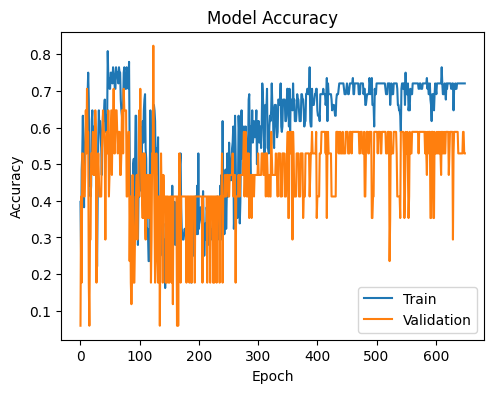

In [92]:
# Cell 20: Plot and save training & validation accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['categorical_accuracy'])
plt.plot(history.history['val_categorical_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='lower right')


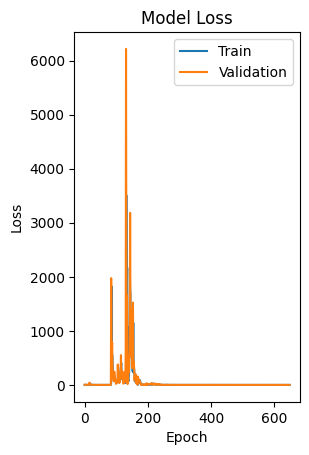

In [93]:
# Cell 21: Plot and save training & validation loss
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Validation'], loc='upper right')

In [94]:
# Save the combined plot
plt.tight_layout()
plt.savefig('graphs/training_history.png')
plt.show()
plt.close()

<Figure size 640x480 with 0 Axes>

In [98]:
# Cell 22: Create and save confusion matrix
from sklearn.metrics import confusion_matrix
import seaborn as sns


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step


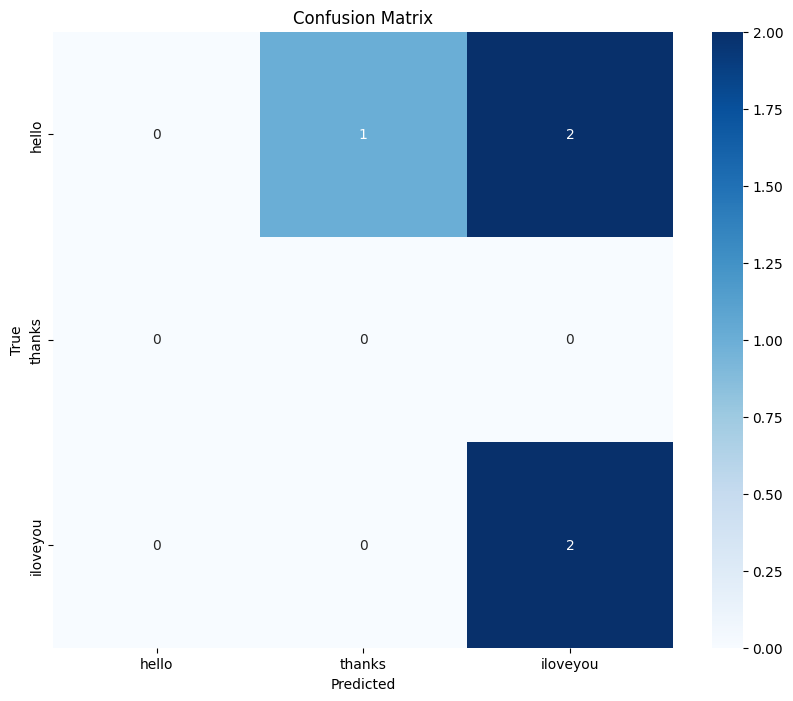

In [99]:
# Get predictions for test data
y_pred = model.predict(X_test)
y_pred_classes = np.argmax(y_pred, axis=1)
y_true = np.argmax(y_test, axis=1)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred_classes)

# Plot confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=actions, yticklabels=actions)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.savefig('graphs/confusion_matrix.png')
plt.show()
plt.close()


C:\Users\User\AppData\Local\Temp\ipykernel_25020\3456041881.py:2: RuntimeWarning: invalid value encountered in divide
  accuracies = cm.diagonal() / cm.sum(axis=1)


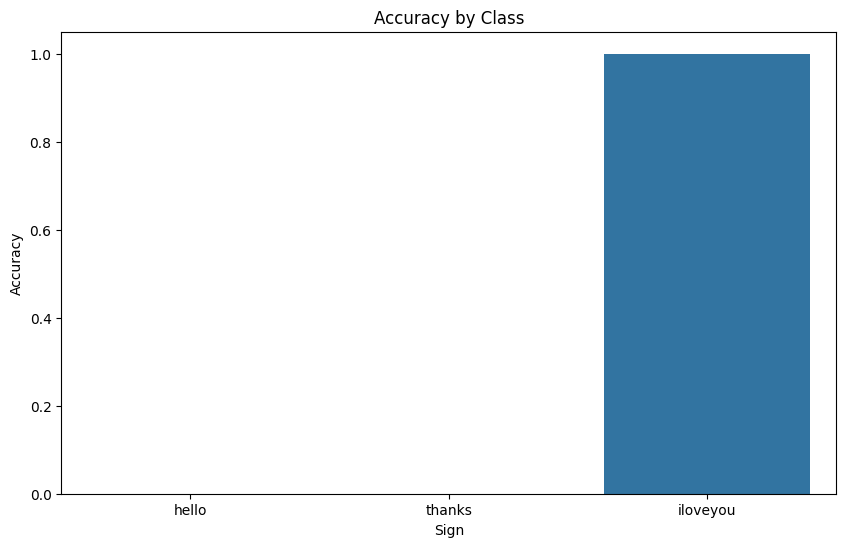

In [100]:
# Cell 23: Plot individual class accuracies
accuracies = cm.diagonal() / cm.sum(axis=1)
plt.figure(figsize=(10, 6))
sns.barplot(x=actions, y=accuracies)
plt.title('Accuracy by Class')
plt.ylabel('Accuracy')
plt.xlabel('Sign')
plt.savefig('graphs/class_accuracies.png')
plt.show()
plt.close()

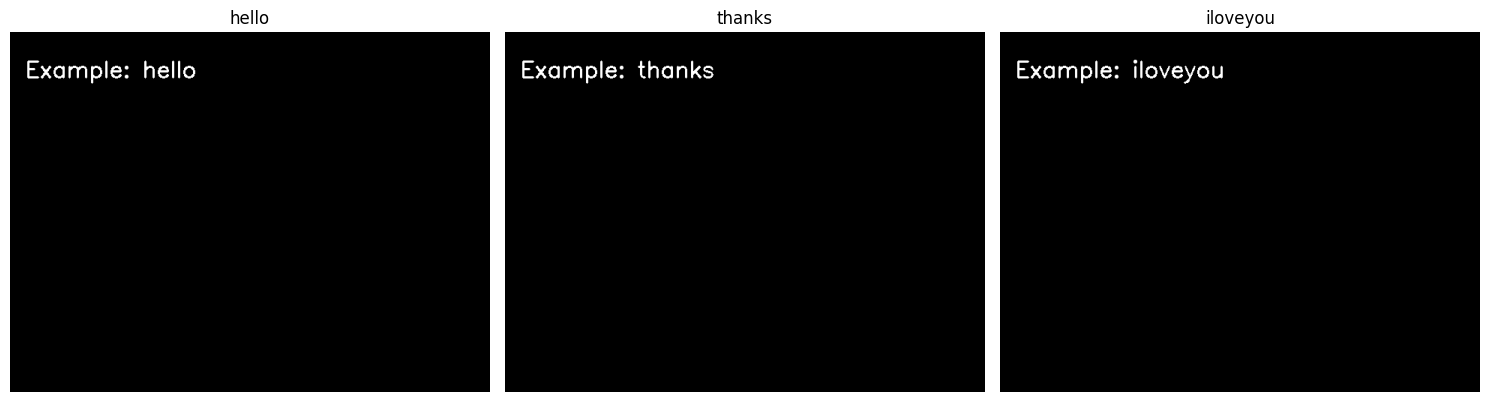

In [101]:
# Cell 24: Create a visualization showing example frames with landmarks for each class
fig = plt.figure(figsize=(15, 10))
for i, action in enumerate(actions):
    sequence_folder = os.path.join(DATA_PATH, action, '0')  # Use the first sequence as example
    frame_file = os.path.join(sequence_folder, '15.npy')  # Use middle frame
    
    # Create a blank image for visualization
    img = np.zeros((480, 640, 3), dtype=np.uint8)
    
    # We need to convert from the saved keypoints back to landmarks format
    # This is a simplified visualization - actual landmarks would need more processing
    keypoints = np.load(frame_file)
    
    # Draw a text label
    cv2.putText(img, f"Example: {action}", (20, 60), cv2.FONT_HERSHEY_SIMPLEX, 1, (255, 255, 255), 2)
    
    # Get subplot position
    plt.subplot(1, 3, i+1)
    plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.title(action)
    plt.axis('off')

plt.tight_layout()
plt.savefig('graphs/example_signs.png')
plt.show()
plt.close()


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 53ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━

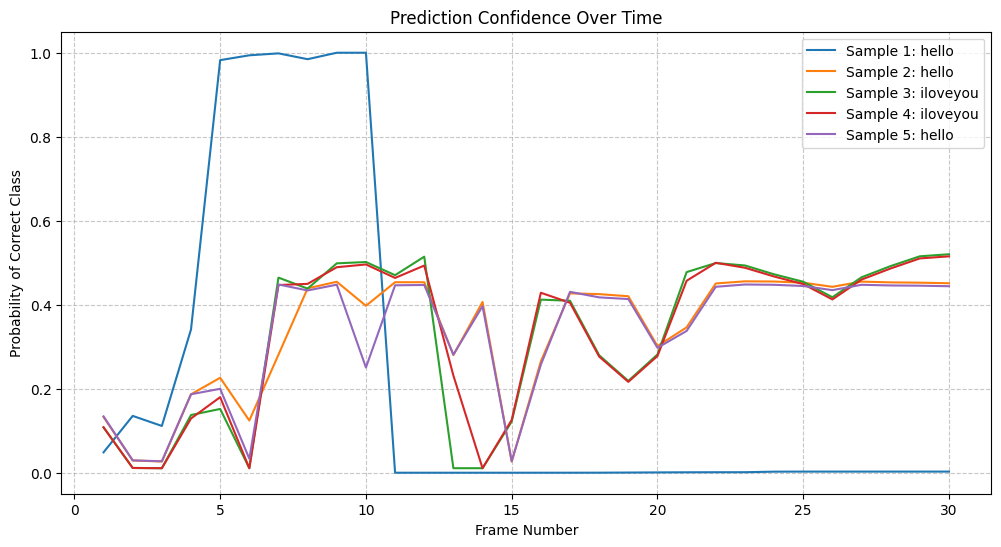

In [102]:
# Cell 25: Save learning curves for individual runs
plt.figure(figsize=(12, 6))
for i in range(len(y_test)):
    prob_sequence = []
    # Simulate a prediction over time (frames)
    for frame in range(30):
        # Create a partial sequence using the first 'frame' number of frames
        test_sequence = X_test[i][:frame+1]
        # Pad the sequence if necessary
        if frame < 29:
            padding = np.zeros((30 - (frame+1), 1662))
            test_sequence = np.vstack([test_sequence, padding])
        # Reshape and predict
        res = model.predict(np.expand_dims(test_sequence, axis=0))[0]
        prob_sequence.append(res[np.argmax(y_test[i])])
    
    # Only plot a few examples to avoid cluttering
    if i < 5:  
        plt.plot(range(1, 31), prob_sequence, label=f'Sample {i+1}: {actions[np.argmax(y_test[i])]}')

plt.title('Prediction Confidence Over Time')
plt.xlabel('Frame Number')
plt.ylabel('Probability of Correct Class')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.7)
plt.savefig('graphs/prediction_confidence_over_time.png')
plt.show()
plt.close()


In [103]:
# Cell 26: Confirmation message for graphs
print("All graphs have been saved to the 'graphs' directory!")


All graphs have been saved to the 'graphs' directory!


In [ ]:
import sys

# Uninstall current versions to avoid conflicts
!{sys.executable} -m pip uninstall -y tensorflowjs tensorflow tf-keras

# Install specific versions known to work together
!{sys.executable} -m pip install tensorflow==2.12.0
!{sys.executable} -m pip install tensorflowjs==4.10.0

  Using cached tensorflow-2.9.0-cp310-cp310-win_amd64.whl.metadata (3.0 kB)
  Using cached flatbuffers-1.12-py2.py3-none-any.whl.metadata (872 bytes)
  Using cached tensorboard-2.9.1-py3-none-any.whl.metadata (1.9 kB)
  Using cached tensorflow_estimator-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached keras-2.9.0-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached protobuf-3.19.6-cp310-cp310-win_amd64.whl.metadata (806 bytes)
  Using cached tensorboard_data_server-0.6.1-py3-none-any.whl.metadata (1.1 kB)
   ---------------------------------------- 0.0/444.1 MB ? eta -:--:--
   ---------------------------------------- 0.3/444.1 MB ? eta -:--:--
   ---------------------------------------- 1.0/444.1 MB 4.6 MB/s eta 0:01:37
   ---------------------------------------- 1.8/444.1 MB 3.6 MB/s eta 0:02:04
   ---------------------------------------- 2.1/444.1 MB 3.4 MB/s eta 0:02:12
   ---------------------------------------- 3.4/444.1 MB 3.8 MB/s eta 0:01:57
   --------------------

ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
mediapipe 0.10.21 requires flatbuffers>=2.0, but you have flatbuffers 1.12 which is incompatible.
mediapipe 0.10.21 requires protobuf<5,>=4.25.3, but you have protobuf 3.19.6 which is incompatible.


  Using cached tensorflowjs-4.22.0-py3-none-any.whl.metadata (3.2 kB)
  Using cached flax-0.10.4-py3-none-any.whl.metadata (11 kB)
  Using cached importlib_resources-6.5.2-py3-none-any.whl.metadata (3.9 kB)
  Using cached tensorflow-2.19.0-cp310-cp310-win_amd64.whl.metadata (4.1 kB)
  Using cached tf_keras-2.19.0-py3-none-any.whl.metadata (1.8 kB)
  Using cached tensorflow_decision_forests-1.8.1.tar.gz (15.2 MB)
  Preparing metadata (setup.py): started
  Preparing metadata (setup.py): finished with status 'done'
  Using cached tensorflow_hub-0.16.1-py2.py3-none-any.whl.metadata (1.3 kB)
  Using cached packaging-23.2-py3-none-any.whl.metadata (3.2 kB)
  Using cached msgpack-1.1.0-cp310-cp310-win_amd64.whl.metadata (8.6 kB)
  Using cached optax-0.2.4-py3-none-any.whl.metadata (8.3 kB)
  Using cached orbax_checkpoint-0.11.10-py3-none-any.whl.metadata (2.0 kB)
  Using cached tensorstore-0.1.72-cp310-cp310-win_amd64.whl.metadata (21 kB)
  Using cached treescope-0.1.9-py3-none-any.whl.metada

   ---- ----------------------------------- 1.3/12.4 MB 1.6 MB/s eta 0:00:07
   ---- ----------------------------------- 1.3/12.4 MB 1.6 MB/s eta 0:00:07
   ------ --------------------------------- 2.1/12.4 MB 1.5 MB/s eta 0:00:07
   -------- ------------------------------- 2.6/12.4 MB 1.8 MB/s eta 0:00:06
   --------- ------------------------------ 2.9/12.4 MB 1.6 MB/s eta 0:00:06
   ----------- ---------------------------- 3.4/12.4 MB 1.7 MB/s eta 0:00:06
   --------------- ------------------------ 4.7/12.4 MB 2.2 MB/s eta 0:00:04
   ---------------- ----------------------- 5.0/12.4 MB 2.1 MB/s eta 0:00:04
   --------------------- ------------------ 6.6/12.4 MB 2.5 MB/s eta 0:00:03
   ---------------------- ----------------- 7.1/12.4 MB 2.6 MB/s eta 0:00:03
   ----------------------- ---------------- 7.3/12.4 MB 2.4 MB/s eta 0:00:03
   --------------------------- ------------ 8.4/12.4 MB 2.6 MB/s eta 0:00:02
   --------------------------- ------------ 8.7/12.4 MB 2.6 MB/s eta 0:00:02

In [ ]:
# Cell 3: Verify installation and imports
import json
import tensorflow as tf
print(f"Installed TensorFlow version: {tf.__version__}")

try:
    import tensorflowjs as tfjs
    print(f"Installed TensorFlow.js version: {tfjs.version.version}")
    print("✅ TensorFlow.js imported successfully")
except Exception as e:
    print(f"❌ Error importing TensorFlow.js: {e}")

AttributeError: module 'tensorflow.compat.v2' has no attribute '__internal__'

In [113]:
# Create a directory for the converted model
os.makedirs('tfjs_model', exist_ok=True)

# Convert the Keras model to TensorFlow.js format
tfjs.converters.save_keras_model(model, 'tfjs_model')

print("Model has been successfully converted to TensorFlow.js format!")
print("The model files are saved in the 'tfjs_model' directory.")


AttributeError: module 'tensorflow' has no attribute 'converters'

In [ ]:
# Cell 29: Create metadata file for the model
metadata = {
    "model_name": "sign_language_recognition",
    "version": "1.0",
    "input_shape": [30, 1662],  # [sequence_length, num_features]
    "output_shape": [len(actions)],  # Number of action classes
    "actions": actions.tolist(),  # List of action names
    "preprocessing": {
        "normalize": False,  # If your data isn't normalized in preprocessing
    }
}

with open('tfjs_model/metadata.json', 'w') as f:
    json.dump(metadata, f, indent=2)

print("Metadata file created.")